In [120]:
from quaternions import *
from networks import *
from helpers_train_test import *
from liegroups.numpy import SO3
import torch
from convex_layers import *
from torch.utils.data import Dataset, DataLoader
from loaders import KITTIVODatasetPreTransformed
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.dpi'] = 90

In [121]:
#Sym / No Norm
#path = 'saved_data/kitti/kitti_model_A_sym_seq_00_01-01-2020-23-16-53.pt'
#path = 'saved_data/kitti/kitti_model_A_sym_seq_02_01-02-2020-00-24-03.pt'
path = 'saved_data/kitti/kitti_model_A_sym_seq_05_01-01-2020-21-52-03.pt'

#PSD / Frob Norm
#path = 'saved_data/kitti/kitti_model_A_sym_seq_00_01-01-2020-18-36-24.pt'
#path = 'saved_data/kitti/kitti_model_A_sym_seq_02_01-01-2020-19-40-50.pt'
#path = 'saved_data/kitti/kitti_model_A_sym_seq_05_01-01-2020-17-09-10.pt'
checkpoint = torch.load(path)
args = checkpoint['args']
print(args)
device = torch.device('cuda:0') if args.cuda else torch.device('cpu')
tensor_type = torch.double if args.double else torch.float

transform = None
seqs_base_path = '/media/m2-drive/datasets/KITTI/single_files'
if args.megalith:
    seqs_base_path = '/media/datasets/KITTI/single_files'
seq_prefix = 'seq_'
kitti_data_pickle_file = 'kitti/kitti_singlefile_data_sequence_{}_delta_1_reverse_True_minta_0.0.pickle'.format(args.seq)
train_loader = DataLoader(KITTIVODatasetPreTransformed(kitti_data_pickle_file, use_flow=args.optical_flow, seqs_base_path=seqs_base_path, transform_img=transform, run_type='train', seq_prefix=seq_prefix),
                            batch_size=args.batch_size_test, pin_memory=False,
                            shuffle=False, num_workers=args.num_workers, drop_last=False)

transform = torchvision.transforms.RandomErasing(p=0.5)
valid_loader = DataLoader(KITTIVODatasetPreTransformed(kitti_data_pickle_file, use_flow=args.optical_flow, seqs_base_path=seqs_base_path, transform_img=transform, run_type='test', seq_prefix=seq_prefix),
                            batch_size=args.batch_size_test, pin_memory=False,
                            shuffle=False, num_workers=args.num_workers, drop_last=False)
print(len(valid_loader))

kitti_data_pickle_file_new = 'kitti/kitti_singlefile_data_sequence_01_delta_1_reverse_True_min_turn_0.0.pickle'
valid_loader2 = DataLoader(KITTIVODatasetPreTransformed(kitti_data_pickle_file_new, use_flow=args.optical_flow, seqs_base_path=seqs_base_path, transform_img=transform, run_type='test', seq_prefix=seq_prefix),
                            batch_size=args.batch_size_test, pin_memory=False,
                            shuffle=False, num_workers=args.num_workers, drop_last=False)
print(len(valid_loader2))

#Train and test with new representation
dim_in = 2 if args.optical_flow else 6

Namespace(batch_size_test=64, batch_size_train=32, batchnorm=True, cuda=True, double=False, enforce_psd=False, epochs=50, lr=0.0001, megalith=True, model='A_sym', num_workers=8, optical_flow=False, save_model=True, seq='05', unit_frob=False)
Loading sequences...['02', '07', '09', '08', '06', '00', '10']
Pose delta: 1
...done loading images into memory.
Loading sequences...['05']
Pose delta: 1
...done loading images into memory.
44
Loading sequences...['01']
Pose delta: 1
...done loading images into memory.
35


In [122]:
print('==============Using A (Sym) MODEL====================')
model = QuatFlowNet(enforce_psd=args.enforce_psd, unit_frob_norm=args.unit_frob, dim_in=dim_in, batchnorm=args.batchnorm).to(device=device, dtype=tensor_type)
valid_loader.dataset.rotmat_targets = False
valid_loader2.dataset.rotmat_targets = False

print('Loading data...')
model.load_state_dict(checkpoint['model'], strict=False)
print('Done')

==============Using A (Sym) MODEL====================
Loading data...
Done


In [123]:
def sorted_els(A):
    el, _ = np.linalg.eig(A)
    el.sort(axis=1)
    return el

def _scatter(ax, x, y, title, color='tab:red', marker=".", size=4):
    ax.scatter(x, y, color=color, s=size, marker=marker, label=title)
    ax.grid()
    ax.legend(loc='lower right')
    return

def evaluate_model(loader):
    q_est = []
    q_target = []
    A_pred = []
    with torch.no_grad():
        model.eval()
        print('Loading...')
        for _, (x, target) in enumerate(loader):
            #Move all data to appropriate device
            x = x.to(device=device, dtype=tensor_type)
            q_est.append(model.forward(x).squeeze().cpu())
            q_target.append(target.cpu())
            A_pred.append(model.output_A(x).cpu())
            
    A_pred = torch.cat(A_pred, dim=0)
    q_est = torch.cat(q_est, dim=0)
    q_target = torch.cat(q_target, dim=0)
    
    return (A_pred, q_est, q_target)

A_predt, q_estt, q_targett = evaluate_model(train_loader)
A_pred, q_est, q_target = evaluate_model(valid_loader)
A_pred2, q_est2, q_target2 = evaluate_model(valid_loader2)


x = torch.rand(500, 6, 224, 224)
x = x.to(device=device, dtype=tensor_type)
model.eval()
with torch.no_grad():
    A = model.output_A(x).cpu()
    
mean_errt = quat_angle_diff(q_estt, q_targett, reduce=True)
mean_err = quat_angle_diff(q_est, q_target, reduce=True)
mean_err2 = quat_angle_diff(q_est2, q_target2, reduce=True)

print('Mean errors (deg): {:.3F} / {:.3F} / {:.3F}'.format(mean_errt.item(), mean_err.item(), mean_err2.item()))

Loading...
Loading...
Loading...
Mean errors (deg): 0.028 / 0.398 / 0.582


Text(0.5, 0, 'Min eigenvalue')

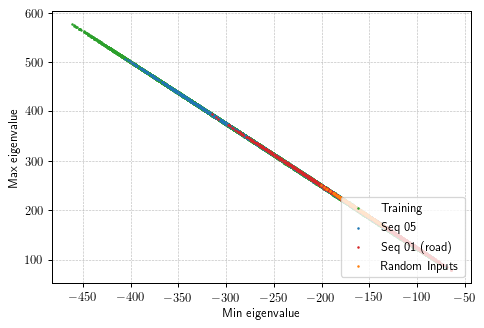

In [124]:

def wigner_log_likelihood(A, reduce=True):
    el, _ = np.linalg.eig(A)
    el.sort(axis=1)
    spacings = np.diff(el, axis=1)
    lls = np.log(spacings) - 0.25*np.pi*(spacings**2)
    if reduce:
        return np.sum(lls, axis=1).mean()
    else:
        return np.sum(lls, axis=1)
    
fig, ax = plt.subplots(1, 1, sharex='col', sharey='row')
_scatter(ax, sorted_els(A_predt.numpy())[:,0], sorted_els(A_predt.numpy())[:,-1], 'Training', color='tab:green')
_scatter(ax, sorted_els(A_pred.numpy())[:,0], sorted_els(A_pred.numpy())[:,-1], 'Seq ' + args.seq , color='tab:blue')
_scatter(ax, sorted_els(A_pred2.numpy())[:,0], sorted_els(A_pred2.numpy())[:,-1], 'Seq 01 (road)', color='tab:red')
_scatter(ax, sorted_els(A.numpy())[:,0], sorted_els(A.numpy())[:,-1], 'Random Inputs', color='tab:orange')

ax.grid(True, which='both', color='tab:grey', linestyle='--', alpha=0.5, linewidth=0.5)
ax.set_ylabel('Max eigenvalue')
ax.set_xlabel('Min eigenvalue')
#ax.set_xlim([-1e-8, 1e-6])
# ax.set_xscale('log')
# ax.set_yscale('log')



[-402733.4184375  -115059.27148438]
[-354924.4165625   -47854.15234375]
[-187282.19921875  -35103.87597656]
[-88818.89523437 -56762.78613281]
Kept 1020/2760
Kept 295/2200
Kept 0/500
All errors (deg): 0.398 / 0.582
Filtered errors (deg): 0.141 / 0.093


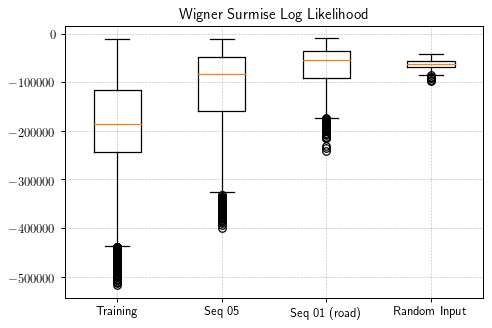

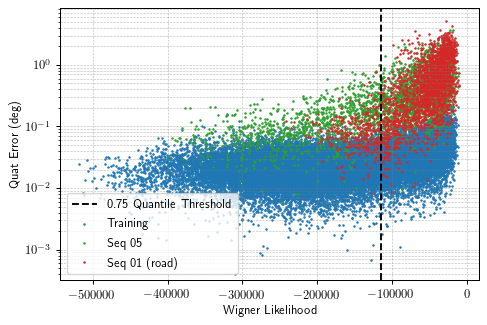

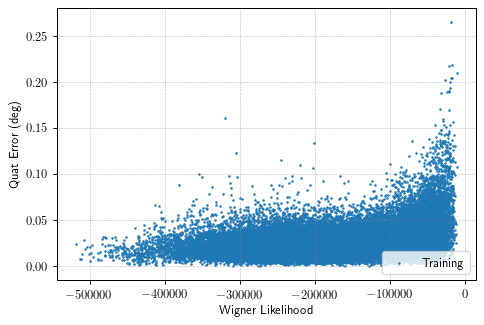

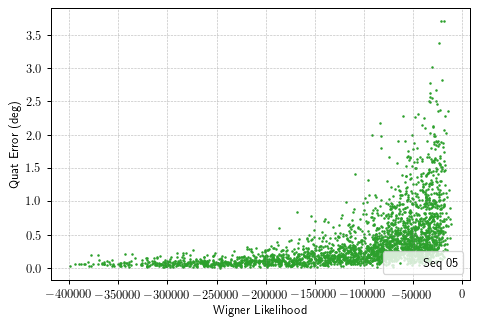

In [130]:

def eig_bounds(A):
    stats = eig_stat(A)
    return np.quantile(stats, [0.01, 0.75])

def eig_stat(A):
    #els = np.abs(sorted_els(A.numpy()))
    #return els[:,0]/els[:,1]
    return wigner_log_likelihood(A, reduce=False)

def bounds_mask(arr, bounds):
    return arr < in_bounds[1]#np.logical_and(arr > in_bounds[0], arr < in_bounds[1])

fig, ax = plt.subplots(1, 1, sharex='col', sharey='row')

ax.boxplot([eig_stat(A_predt),eig_stat(A_pred), eig_stat(A_pred2), eig_stat(A)], labels=['Training', 'Seq ' + args.seq, 'Seq 01 (road)', 'Random Input'])

# _scatter(ax, np.ones(A_predt.shape[0]), eig_stat(A_predt), 'Training', color='tab:blue')
# _scatter(ax, 2.*np.ones(A_pred.shape[0]), eig_stat(A_pred), 'Seq 00', color='tab:red')
# _scatter(ax, 3.*np.ones(A_pred2.shape[0]), eig_stat(A_pred2), 'Seq 04', color='tab:green')
# _scatter(ax, 4.*np.ones(A.shape[0]), eig_stat(A), 'Random', color='tab:orange')
ax.set_title('Wigner Surmise Log Likelihood')
ax.grid(True, which='both', color='tab:grey', linestyle='--', alpha=0.5, linewidth=0.5)
#ax.set_yscale('log')

print(eig_bounds(A_predt))
print(eig_bounds(A_pred))
print(eig_bounds(A_pred2))
print(eig_bounds(A))

in_bounds = eig_bounds(A_predt)
mask = bounds_mask(eig_stat(A_pred), in_bounds)
print('Kept {}/{}'.format(mask.sum(), mask.shape[0]))
mask2 = bounds_mask(eig_stat(A_pred2), in_bounds)
print('Kept {}/{}'.format(mask2.sum(), mask2.shape[0]))
mask_rand = bounds_mask(eig_stat(A), in_bounds)
print('Kept {}/{}'.format(mask_rand.sum(), mask_rand.shape[0]))


mean_err = quat_angle_diff(q_est, q_target, reduce=False)
mean_err2 = quat_angle_diff(q_est2, q_target2, reduce=False)
print('All errors (deg): {:.3F} / {:.3F}'.format(mean_err.mean(), mean_err2.mean()))

fig, ax = plt.subplots(1, 1, sharex='col', sharey='row')
ax.axvline(in_bounds[1],c='k', ls='--', label='0.75 Quantile Threshold')
_scatter(ax, eig_stat(A_predt), quat_angle_diff(q_estt, q_targett, reduce=False), 'Training', color='tab:blue')
_scatter(ax, eig_stat(A_pred), mean_err, 'Seq ' + args.seq, color='tab:green')
_scatter(ax, eig_stat(A_pred2),mean_err2, 'Seq 01 (road)', color='tab:red')
ax.legend(loc='lower left')
ax.grid(True, which='both', color='tab:grey', linestyle='--', alpha=0.5, linewidth=0.5)
ax.set_ylabel('Quat Error (deg)')
ax.set_xlabel('Wigner Likelihood')
ax.set_yscale('log')

fig, ax = plt.subplots(1, 1, sharex='col', sharey='row')
_scatter(ax, eig_stat(A_predt), quat_angle_diff(q_estt, q_targett, reduce=False), 'Training', color='tab:blue')
ax.grid(True, which='both', color='tab:grey', linestyle='--', alpha=0.5, linewidth=0.5)
ax.set_ylabel('Quat Error (deg)')
ax.set_xlabel('Wigner Likelihood')



fig, ax = plt.subplots(1, 1, sharex='col', sharey='row')
_scatter(ax, eig_stat(A_pred), mean_err, 'Seq ' + args.seq, color='tab:green')
ax.grid(True, which='both', color='tab:grey', linestyle='--', alpha=0.5, linewidth=0.5)
ax.set_ylabel('Quat Error (deg)')
ax.set_xlabel('Wigner Likelihood')


mean_err = quat_angle_diff(q_est[mask], q_target[mask])
mean_err2 = quat_angle_diff(q_est2[mask2], q_target2[mask2])
print('Filtered errors (deg): {:.3F} / {:.3F}'.format(mean_err, mean_err2))





In [126]:
def q_identity(N, ordering='xyzw'):
    q_ident = torch.zeros((N, 4))
    if ordering == 'xyzw':
        one_idx = 3
    else:
        one_idx = 0
    q_ident[:, one_idx] = 1.
    return q_ident

mean_err = quat_angle_diff(q_identity(q_target.shape[0]), q_target, reduce=True)
mean_err2 = quat_angle_diff(q_identity(q_target2.shape[0]), q_target2, reduce=True)
print('Mean errors (deg): {:.3F} / {:.3F}'.format(mean_err.item(), mean_err2.item()))

Mean errors (deg): 0.527 / 0.443
